In [7]:
from dataclasses import dataclass

import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes
from utils import gauss_cgs

# Magnetic field

Uniform $B_0$ field in X direction with Alfven-wave perturbation with small amplitude $\delta B << B_0$

TODO: $\delta B$ must be a spectrum not a monochromatic wave!


In [8]:
B0 = 1e-6 * gauss_cgs
deltaB = 1e-2 * B0

# plasma density
n_IMP = 1 / u.cm**3
rho_IMP = n_IMP * const.m_p
v_A = (B0 / np.sqrt(rho_IMP)).to(u.km / u.s)
print(f"v_A = {v_A:.2f} ({(v_A / const.c).decompose():.2e} * speed of light)")


@dataclass
class Particle:
    E: u.Quantity[u.eV]
    theta: float

    gamma: float
    v: u.Quantity[u.km / u.s]

    R_L: u.Quantity[u.au]
    Omega_L: u.Quantity[1 / u.day]
    T_L: u.Quantity[u.day]

    k_res: u.Quantity[1 / u.au]
    w_res: u.Quantity[1 / u.kyr]
    lambda_res: u.Quantity[u.au]

    def __str__(self) -> str:
        return "\n".join(
            [
                f"proton with E = {self.E:.2f} pitch angle = {180 * self.theta / np.pi}",
                f"v = {self.v / const.c:.2e} c; gamma = {self.gamma:.2e}",
                f"gyration params: R = {self.R_L:.2f} T = {self.T_L:.2f}",
                f"resonance conditions: k = {self.k_res:.2e}; wavelength = {self.lambda_res:.2f}",
            ]
        )

    @classmethod
    def from_energy_pitch_angle(cls, E: u.Quantity[u.eV], theta: float):
        gamma = (E / (const.m_p * const.c**2)).decompose()
        v = const.c * np.sqrt(1 - gamma ** (-2))
        R_L = (
            (gamma * const.m_p * v * np.sin(theta)) * const.c / (const.e.gauss * B0)
        ).to(u.au)
        k_res = (np.tan(theta) / R_L).to(1 / u.au)

        return Particle(
            E=E,
            theta=theta,
            gamma=gamma,
            v=v,
            R_L=R_L,
            Omega_L=v * np.sin(theta) / R_L,
            T_L=((2 * np.pi * R_L) / (v * np.sin(theta))).to(u.day),
            k_res=k_res,
            w_res=(k_res * v_A).to(1 / u.kyr),
            lambda_res=1 / k_res,
        )


print(Particle.from_energy_pitch_angle(E=1 * u.TeV, theta=np.pi / 4))

v_A = 7.73 km / s (2.58e-05 * speed of light)
proton with E = 1.00 TeV pitch angle = 45.0
v = 1.00e+00 c; gamma = 1.07e+03
gyration params: R = 157.67 AU T = 8.09 d
resonance conditions: k = 6.34e-03 1 / AU; wavelength = 157.67 AU


In [9]:
def B_field(
    x: u.Quantity[u.au],
    y: u.Quantity[u.au],
    z: u.Quantity[u.au],
    t: u.Quantity[u.kyr],
    k: u.Quantity[1 / u.au],
    phase: float = 0.0,
) -> tuple[u.Quantity[gauss_cgs], ...]:
    assert x.shape == y.shape == z.shape
    B_x = B0 * np.ones_like(x).value
    w = (k * v_A).to(1 / u.kyr)
    B_y = deltaB * np.cos((k * x - w * t).decompose().value + phase)
    B_z = deltaB * np.sin((k * x - w * t).decompose().value + phase)
    return B_x, B_y, B_z

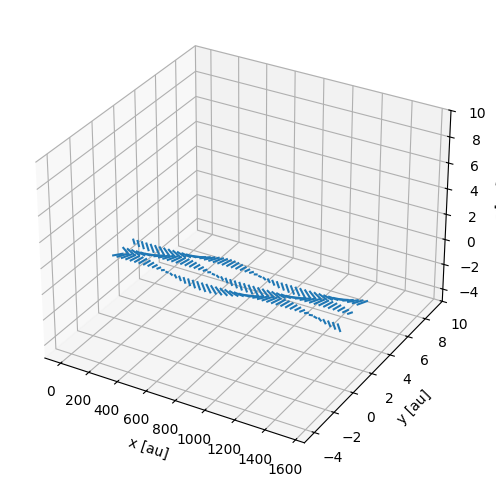

In [10]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

ax = plt.figure(figsize=(8, 6)).add_subplot(projection="3d")
ax: Axes3D

example_particle = Particle.from_energy_pitch_angle(E=1000 * u.GeV, theta=np.pi / 4)
x_grid = (
    np.arange(0, 10 * example_particle.R_L.value, step=0.2 * example_particle.R_L.value)
    * u.au
)
transverse_grid = np.array([0]) * u.au
x, y, z = np.meshgrid(x_grid, transverse_grid, transverse_grid)

for idx, t_frac in enumerate((0, 0.25, 0.5)):
    t = (2 * np.pi / example_particle.w_res) * t_frac
    B_x, B_y, B_z = B_field(x, y, z, t, example_particle.k_res)
    ax.quiver(
        x,
        (idx * u.au) + y,
        z,
        B_x,
        B_y,
        B_z,
        length=(0.3 * example_particle.R_L.value),
        normalize=True,
        arrow_length_ratio=0,
    )

ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")
ax.set_zlabel("z [au]")

ax.set_ylim(-5, 10)
ax.set_zlim(-5, 10)

plt.show()

# Full numerical integration to obtain particle trajectory

To pass the problem to the ODE solver, we need to rewrite it in standard form
$\frac{d \vec{\theta}}{dt} = f(t, \vec{\theta})$ with initial condition
$\vec \theta(t_0) = \vec \theta_0$. For our problem we can use

$$
\theta = \begin{pmatrix}
v_x \\
v_y \\
v_z \\
x \\
y \\
z \\
\end{pmatrix}
$$

Then,

$$
f = \begin{pmatrix}
\frac{q}{c m \gamma(v)} (v_y B_z - v_z B_y) \\
\frac{q}{c m \gamma(v)} (-v_x B_z + v_z B_x) \\
\frac{q}{c m \gamma(v)} (v_x B_y - v_y B_x) \\
v_x \\
v_y \\
v_z \\
\end{pmatrix}


$$


In [11]:
from typing import Literal
from tqdm import tqdm


L_UNIT = u.au
T_UNIT = u.day
V_UNIT = L_UNIT / T_UNIT
A_UNIT = L_UNIT / (T_UNIT**2)
Approx = Literal["no-wave", "qlt", "full"]
APPROX_OPTS: list[Approx] = ["no-wave", "qlt", "full"]


def get_ode_rhs(k: u.Quantity[1 / u.au], B_phase: float, gamma: float, approx: Approx):
    lorentz_force_norm = const.e.gauss / (const.c * const.m_p * gamma)

    def f(
        t: float, params: np.ndarray, pbar: tqdm | None = None, verbose: bool = False
    ) -> np.ndarray:
        if pbar is not None:
            pbar.update()
        if verbose:
            print()
            print("t =", t)
            print("params =", params)
        if not np.all(np.isfinite(params)):
            raise ValueError(f"got NaN params: {params}")

        vx, vy, vz, x, y, z = params
        vx = vx * V_UNIT
        vy = vy * V_UNIT
        vz = vz * V_UNIT
        x = x * L_UNIT
        y = y * L_UNIT
        z = z * L_UNIT
        t = t * T_UNIT

        Bx, By, Bz = B_field(x, y, z, t, k, phase=B_phase)
        if verbose:
            print(f"B = [{Bx}, {By}, {Bz}]")

        perturb_x = False if approx == "no-wave" else True
        perturb_trans = True if approx == "full" else False
        result = np.array(
            [
                (
                    (lorentz_force_norm * (vy * Bz - vz * By)).to(A_UNIT).value
                    if perturb_x
                    else 0
                ),
                (lorentz_force_norm * (vz * Bx - (vx * Bz if perturb_trans else 0)))
                .to(A_UNIT)
                .value,
                (lorentz_force_norm * (-vy * Bx + (vx * By if perturb_trans else 0)))
                .to(A_UNIT)
                .value,
                vx.value,
                vy.value,
                vz.value,
            ]
        )
        if verbose:
            print("result:", result)
        if not np.all(np.isfinite(result)):
            raise RuntimeError(f"Non-finite values in RHS: {result}")
        return result

    return f


def get_ode_initial(E: u.Quantity[u.eV], theta: float) -> np.ndarray:
    gamma = (E / (const.m_p * const.c**2)).decompose()
    v = const.c * np.sqrt(1 - gamma ** (-2))
    vx = v * np.cos(theta)
    v_trans = v * np.sin(theta)
    phi = np.random.random() * np.pi * 2
    return np.array(
        [
            vx.to(V_UNIT).value,
            (v_trans * np.cos(phi)).to(V_UNIT).value,
            (v_trans * np.sin(phi)).to(V_UNIT).value,
            0,
            0,
            0,
        ]
    )

In [12]:
from scipy.integrate import solve_ivp

E = 1000 * u.GeV
gamma = E / (const.m_p * const.c**2)
theta = np.pi / 4
particle = Particle.from_energy_pitch_angle(E=E, theta=theta)

t_max = 500 * particle.T_L
print(f"integrating up to t = {t_max:.2f}")
t_eval = (
    np.arange(0, t_max.to(T_UNIT).value, particle.T_L.to(T_UNIT).value / 30) * T_UNIT
)

solutions: dict[Approx, np.ndarray] = dict()
theta0 = get_ode_initial(E, theta)
# for approx in ("full",):
for approx in APPROX_OPTS:
    with tqdm(unit="eval") as pbar:
        solution = solve_ivp(
            fun=get_ode_rhs(
                k=particle.k_res,
                B_phase=np.pi / 3,
                gamma=gamma,
                approx=approx,
            ),
            t_span=(0, t_max.to(T_UNIT).value),
            y0=theta0,
            t_eval=t_eval.to(T_UNIT).value,
            method="RK45",
            args=[pbar, False],
            max_step=(particle.T_L / 100).to(T_UNIT).value,
        )
    solutions[approx] = solution.y

integrating up to t = 4045.71 d


300026eval [01:38, 3049.67eval/s]
300026eval [02:04, 2413.97eval/s]
300026eval [01:52, 2664.34eval/s]


In [13]:
def pitch_angle(solution: np.ndarray) -> np.ndarray:
    vx = solution[0, :]
    vy = solution[1, :]
    vz = solution[2, :]
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    mu = vx / v
    return (180 * np.arccos(mu) / np.pi) * u.deg


def period_average(
    t: u.Quantity[u.yr], value: u.Quantity, window: u.Quantity[u.yr]
) -> u.Quantity:
    t_step = t[1] - t[0]
    ma_steps_raw = (window / t_step).decompose()
    ma_steps = int(round(ma_steps_raw.value))
    ma = lambda arr: np.convolve(arr, np.ones(ma_steps) / ma_steps, "valid")
    return ma(t), ma(value)

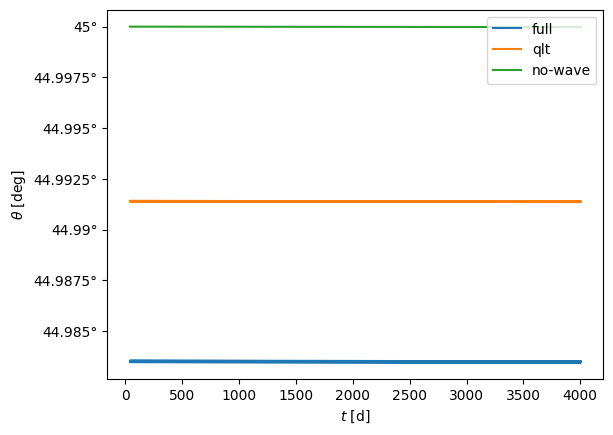

In [14]:
_, ax = plt.subplots()

for approx, solution in list(reversed(solutions.items())):
    ax.plot(
        *period_average(t_eval, pitch_angle(solution), window=10 * particle.T_L),
        label=approx,
    )

# ax.axhline(180 * theta / np.pi, color="k", linestyle="--")
label_axes(ax, "t", "\\theta")
ax.legend()
plt.show()

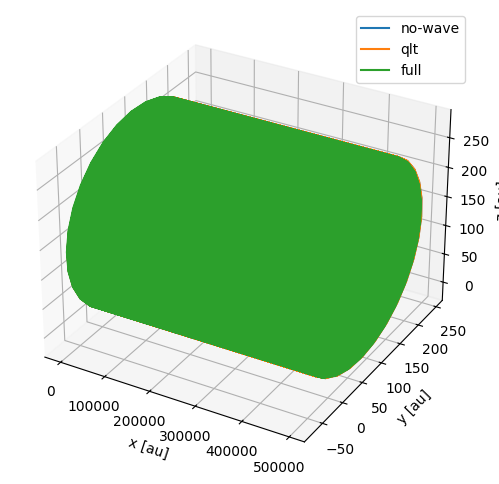

In [15]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

ax = plt.figure(figsize=(8, 6)).add_subplot(projection="3d")
ax: Axes3D

for approx, solution in solutions.items():
    ax.plot(
        solution[3, :],
        solution[4, :],
        solution[5, :],
        label=approx,
    )

ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")
ax.set_zlabel("z [au]")

ax.legend()
plt.show()

# Numerical integration of QLT equation for pitch angle

$$
\frac{d \mu}{dt} = \Omega \frac{\delta B}{B_0} \sqrt{1 - \mu^2} \cos((\Omega + \omega) t - k v \mu)
$$

In [16]:
# TODO...